__Första modellutkast - Random Forrest__

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# Necessary Sklearn objects used in the analysis
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
df1 = pd.read_excel('DataV75TillUffe_2019-02-01_2.xlsx')

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17994 entries, 0 to 17993
Data columns (total 38 columns):
Datum          17994 non-null datetime64[ns]
Utdelning      17994 non-null int64
Arstid         17994 non-null int64
Distans        17994 non-null int64
Startsatt      17994 non-null int64
Lopp           17994 non-null int64
Plac           17994 non-null int64
Hast           17994 non-null int64
V75PROC        17994 non-null float64
V_ODDS         17994 non-null float64
GRUPP          17994 non-null int64
VLP            17994 non-null float64
VNUM           17994 non-null int64
SVLP           17994 non-null float64
VSVLP          17994 non-null float64
VPN_SUM        17994 non-null float64
VPN_SUM_ORD    17994 non-null int64
VPK_SUM        17994 non-null float64
VPK_SUM_ORD    17994 non-null int64
VLPB           17994 non-null float64
SVLPB          17994 non-null float64
VSVLPB         17994 non-null float64
E_P            17994 non-null float64
E_P_Num        17994 non-null in

In [7]:
df1.Plac.value_counts()

0    16439
1     1555
Name: Plac, dtype: int64

In [8]:
df1.Datum.drop_duplicates().count()

222

In [9]:
222*7

1554

In [10]:
# Skapar en unik nyckel på lopp: Gör om Datum och lopp till en sträng

df1['cdate'] = df1.Datum.astype('object')
df1['cLopp'] = df1.Lopp.astype('object')

In [11]:
df1['Key'] = df1['cdate'].astype(str) + df1['cLopp'].astype(str)

In [12]:
len(df1)

17994

In [13]:
df1.Key.drop_duplicates().count()

1554

__Skapar en målvariabel - vinnare__

In [14]:
df1['Y'] = np.where(df1['Plac'].isin([1]), 1,0)

__Nu plockar vi ut 10 v75 omgångar för att använda dem som test__

In [15]:
v75 = df1.Datum.drop_duplicates().to_frame()

In [16]:
len(v75)

222

In [17]:
v75['is_test']=np.random.uniform(0,1,len(v75))<=0.05

test, basedf = v75[v75['is_test']==True], v75[v75['is_test']==False]

__Skapar en kopia, droppar de variabler som inte ska vara med i analysen samt sätter index__

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17994 entries, 0 to 17993
Data columns (total 42 columns):
Datum          17994 non-null datetime64[ns]
Utdelning      17994 non-null int64
Arstid         17994 non-null int64
Distans        17994 non-null int64
Startsatt      17994 non-null int64
Lopp           17994 non-null int64
Plac           17994 non-null int64
Hast           17994 non-null int64
V75PROC        17994 non-null float64
V_ODDS         17994 non-null float64
GRUPP          17994 non-null int64
VLP            17994 non-null float64
VNUM           17994 non-null int64
SVLP           17994 non-null float64
VSVLP          17994 non-null float64
VPN_SUM        17994 non-null float64
VPN_SUM_ORD    17994 non-null int64
VPK_SUM        17994 non-null float64
VPK_SUM_ORD    17994 non-null int64
VLPB           17994 non-null float64
SVLPB          17994 non-null float64
VSVLPB         17994 non-null float64
E_P            17994 non-null float64
E_P_Num        17994 non-null in

In [19]:
df2 = df1[(df1.Datum > '2016-05-20') & (df1.Datum.isin(basedf.Datum.tolist()))]. \
drop(['Utdelning','Datum','Arstid','Distans','Startsatt','Lopp','Plac','Hast','cdate','cLopp','VNUM','V_ODDS'], axis = 1). \
copy().set_index(['Key'])

In [20]:
test_df =  df1[(df1.Datum > '2016-05-20') & (df1.Datum.isin(test.Datum.tolist()))]. \
drop(['Utdelning','Arstid','Distans','Startsatt','Lopp','Plac','Hast','cdate','cLopp','VNUM','V_ODDS'], axis = 1). \
copy().set_index(['Key'])

In [21]:
len(df2)

16953

In [22]:
len(test_df)

1041

__Gör om GRUPP till objekt för att kunna använda befintlig dummylogik__

In [23]:
df2['GRUPP'] = df2.GRUPP.astype('object')

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16953 entries, 2016-05-21 00:00:001 to 2019-01-05 00:00:007
Data columns (total 29 columns):
V75PROC        16953 non-null float64
GRUPP          16953 non-null object
VLP            16953 non-null float64
SVLP           16953 non-null float64
VSVLP          16953 non-null float64
VPN_SUM        16953 non-null float64
VPN_SUM_ORD    16953 non-null int64
VPK_SUM        16953 non-null float64
VPK_SUM_ORD    16953 non-null int64
VLPB           16953 non-null float64
SVLPB          16953 non-null float64
VSVLPB         16953 non-null float64
E_P            16953 non-null float64
E_P_Num        16953 non-null int64
E_N            16953 non-null float64
E_R            16953 non-null float64
E_U            16953 non-null float64
G_R            15284 non-null float64
S_R            14480 non-null float64
A_R            14439 non-null float64
T_R            15358 non-null float64
SP_R           4327 non-null float64
ToR            14322 non-null floa

__Delar upp i numeriska samt charachter attribut. Det är dessa som går in i modellen__

In [25]:
num_attribs = []
cat_attribs = []
for var, typ in zip(df2.columns[:-1], df2.dtypes[:-1]):
    if typ == 'object':
        cat_attribs.append(var)
    else:
        num_attribs.append(var)       

In [26]:
cat_attribs

['GRUPP']

In [27]:
num_attribs

['V75PROC',
 'VLP',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_R',
 'E_U',
 'G_R',
 'S_R',
 'A_R',
 'T_R',
 'SP_R',
 'ToR',
 'P_R',
 'TK_R',
 'Ex_R',
 'R_R',
 'Ts_R']

In [28]:
len(num_attribs)

27

In [29]:
name_list = []
tempdf = pd.get_dummies(df1.GRUPP)
for val in tempdf.columns:
    name_list.append('GRUPP'+str(val))
        
name_list    

['GRUPP1', 'GRUPP2', 'GRUPP3', 'GRUPP4', 'GRUPP5']

In [30]:
features_list = num_attribs + name_list
features_list

['V75PROC',
 'VLP',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_R',
 'E_U',
 'G_R',
 'S_R',
 'A_R',
 'T_R',
 'SP_R',
 'ToR',
 'P_R',
 'TK_R',
 'Ex_R',
 'R_R',
 'Ts_R',
 'GRUPP1',
 'GRUPP2',
 'GRUPP3',
 'GRUPP4',
 'GRUPP5']

__Nu bygger vi upp en pipeline__

In [31]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# Denna klass måste vi göra för att särskilja numeriska variabler mot character variabler
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [32]:
# Egen klass för att sätta dummyvariabler

class SetDummyVar(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tempdf = pd.get_dummies(X[self.attribute_names], columns = self.attribute_names)
        return tempdf.values

In [33]:
# Pipeline för numeriska variabler
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median"))
    ])

cat_pipeline = Pipeline([
        ('dummy_cat', SetDummyVar(cat_attribs)),
    ])

In [34]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

### In order to avoid overfitting data is split into training data and validation data. 75% träningsdata och 25% valideringsdata

In [35]:
df2['is_train']=np.random.uniform(0,1,len(df2))<=0.75

train, validate = df2[df2['is_train']==True], df2[df2['is_train']==False]

In [36]:
type(train)

pandas.core.frame.DataFrame

### Nu skapar vi arrayer som ska användas av modellen - använder den skapade Pipelineobjektet som gör alla nödvändiga dataransformationer 

In [37]:
# Träningssdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_train = full_pipeline.fit_transform(train)
## En array som håller det vi vill predikter
label_train = train["Y"].copy()

In [38]:
features_train[1][28:]

array([0., 0., 0., 1.])

In [39]:
# Valideringsdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_validate = full_pipeline.fit_transform(validate)
## En array som håller det vi vill predikter
label_validate = validate["Y"].copy()

# Train the model on the training data and then evaluate on the validation data

- predicts: A twodimensional array that contains posterrior probabbility for a donation behaviour, one for non-donation and one for donation
- fpr : False positive rate, number of false positive for a specific threshold value
- tpr : True positive rate, number of true positive for a specific threshold value
- threshold: Sorted threshold (descending) values for the likelihod to donate
- roc_auc: Receiver operating characteristics. A value close to 1 indicates a strong model. A value close to 0.5 means that the model is rather poor

In [40]:
# Bygger random forrest och analyserar roc_auc
# Instansierar modellen
rf = RandomForestClassifier(n_estimators = 1000, max_depth=5)

# Tränar modellen

rf.fit(features_train,label_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
rf.n_features_

32

In [42]:
len(rf.feature_importances_)

32

In [43]:
rf.feature_importances_

array([0.24944671, 0.01987647, 0.0169757 , 0.00994001, 0.02198843,
       0.00918468, 0.03630565, 0.02807222, 0.01912972, 0.02152837,
       0.02217916, 0.01971237, 0.00473377, 0.01032861, 0.01367626,
       0.01152827, 0.00645802, 0.01028464, 0.03688841, 0.05238752,
       0.00287713, 0.00662009, 0.04835967, 0.00644301, 0.01067321,
       0.01899002, 0.07202431, 0.14806495, 0.03021684, 0.00729931,
       0.00648725, 0.02131923])

In [44]:
weight_list = []
for name, weight in zip(features_list, rf.feature_importances_):
    weight_dict = {'Feature': name, 'Weight': weight}
    weight_list.append(weight_dict)

In [45]:
analys_weight = pd.DataFrame(weight_list).sort_values('Weight', ascending = False)

analys_weight

,Feature,Weight
0,V75PROC,0.249447
27,GRUPP1,0.148065
26,Ts_R,0.072024
19,T_R,0.052388
22,P_R,0.048360
18,A_R,0.036888
6,VPK_SUM,0.036306
28,GRUPP2,0.030217
7,VPK_SUM_ORD,0.028072
10,VSVLPB,0.022179


In [46]:
analys_weight.to_excel('Weight.xlsx', index = False)

In [47]:
# Predikterar med modellen med valideringsdata

predict = rf.predict_proba(features_validate)

fpr, tpr, threshold = roc_curve(label_validate,predict[:,1])

roc_auc = auc(fpr,tpr)

In [48]:
fpr_ser = pd.Series(fpr)
tpr_ser = pd.Series(tpr)
threshold_ser = pd.Series(threshold)

__Vi gör en dataframe av fpr, tpr, threshold för att förstå relationerna__

In [49]:
# Exempel
df = pd.concat([fpr_ser, tpr_ser,threshold_ser], axis=1).rename(columns = {0: 'fpr', 1:'tpr',2:'threshold'})

In [50]:
# Median värde för den sannolikhet som genereras på varje enskild observation
prob = pd.Series(predict[:,1])
prob.median()

0.04728592234929072

In [51]:
prob.max()

0.7907255070249457

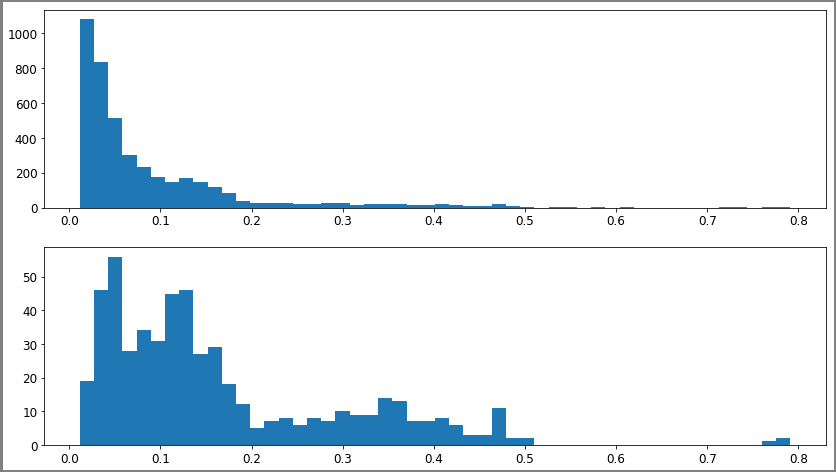

In [52]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8), linewidth=5, edgecolor='.5')


ax1.hist(prob, bins = 50)
ax2.hist(threshold, bins = 50)

plt.show()

In [53]:
df.threshold.median()

0.12584943112289512

__Varför ger threshold och prob olika medianvärden?__

# A ROC curve for the charity classifier on the charity data

__It traces out two types of error as we vary the threshold value for the posterior probability of charity. The actual thresholds are not shown. The true positive rate is the sensitivity: the fraction of givers that are correctly identified, using a given threshold value. The false positive rate is 1-specificity: the fraction of non-givers that we classify incorrectly as givers, using that same threshold value. The ideal ROC curve hugs the top left corner, indicating a high true positive rate and a low false positive rate. The dotted line represents the “no information” classifier.__ 

Saving figure ROC


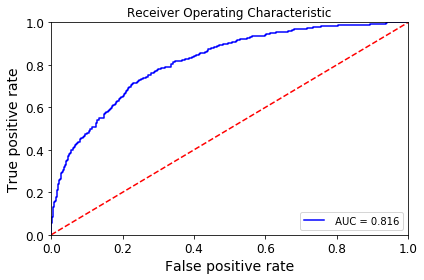

In [54]:
# Graf

plt.title('Receiver Operating Characteristic') 
plt.plot( fpr, tpr, 'b', label =' AUC = %0.3f' % roc_auc) 
plt.legend( loc ='lower right') 
plt.plot([ 0, 1], [0, 1], 'r--') 
plt.xlim([ 0.0, 1.0]) 
plt.ylim([ 0.0, 1.0]) 
plt.ylabel('True positive rate') 
plt.xlabel('False positive rate') 
save_fig('ROC')
plt.show()

In [55]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(label_validate, prob)

Saving figure precision_recall_vs_threshold_plot


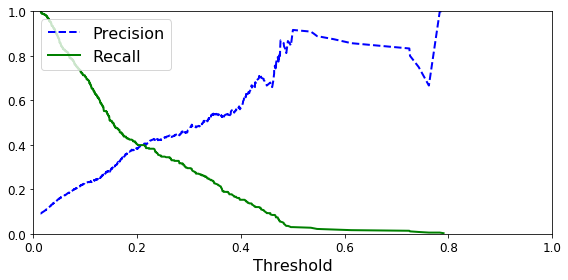

In [56]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [58]:
 
y_truth = label_validate
confusion_matrix(label_validate, y_truth)

array([[3855,    0],
       [   0,  366]])

In [59]:
prob.median()

0.04728592234929072

In [60]:
df.threshold.median()

0.12584943112289512

In [61]:
# Vi väljer medianvärdet som cut off 
y_pred = np.where( prob > prob.median(),1,0)
 
confusion_matrix(label_validate, y_pred)

array([[2069, 1786],
       [  42,  324]])

In [62]:
346 / (1764 + 346)

0.16398104265402844

In [63]:
# Precision - Av de vi predikterar som vinnare, hur bra är vi
precision_score(label_validate, y_pred)

0.15355450236966825

In [64]:
# True positive rate = Den totala andelen av sanna postiva vid en given cut of
recall_score(label_validate, y_pred)
 

0.8852459016393442

In [65]:
label_validate_ser = pd.Series(label_validate.tolist())
prob_ser = pd.Series(prob)

In [66]:
df_valid = pd.concat([label_validate_ser, prob_ser], axis = 1).rename(columns = {0:'Y',1 :'Prob'}). \
sort_values('Prob')

__Delar in i deciler på den framräknade scoren__

In [67]:
data = df_valid.Prob.values
quartiles = pd.qcut(data, 10)
pd.value_counts(quartiles)

(0.010599999999999998, 0.0169]    423
(0.184, 0.791]                    422
(0.13, 0.184]                     422
(0.0893, 0.13]                    422
(0.0639, 0.0893]                  422
(0.0473, 0.0639]                  422
(0.0376, 0.0473]                  422
(0.0303, 0.0376]                  422
(0.0241, 0.0303]                  422
(0.0169, 0.0241]                  422
dtype: int64

In [68]:
df_valid.Y.sum()

366

In [69]:
grouped = df_valid.Y.groupby(quartiles)

In [70]:
grouped.count()

(0.010599999999999998, 0.0169]    423
(0.0169, 0.0241]                  422
(0.0241, 0.0303]                  422
(0.0303, 0.0376]                  422
(0.0376, 0.0473]                  422
(0.0473, 0.0639]                  422
(0.0639, 0.0893]                  422
(0.0893, 0.13]                    422
(0.13, 0.184]                     422
(0.184, 0.791]                    422
Name: Y, dtype: int64

__Beräknar den procentuella andelen vinnare i respektice decil__

In [71]:
resp = round((grouped.sum() / grouped.count() * 100))
resp

(0.010599999999999998, 0.0169]     1.0
(0.0169, 0.0241]                   0.0
(0.0241, 0.0303]                   2.0
(0.0303, 0.0376]                   3.0
(0.0376, 0.0473]                   4.0
(0.0473, 0.0639]                   6.0
(0.0639, 0.0893]                   7.0
(0.0893, 0.13]                    13.0
(0.13, 0.184]                     14.0
(0.184, 0.791]                    37.0
Name: Y, dtype: float64

Saving figure Probdist


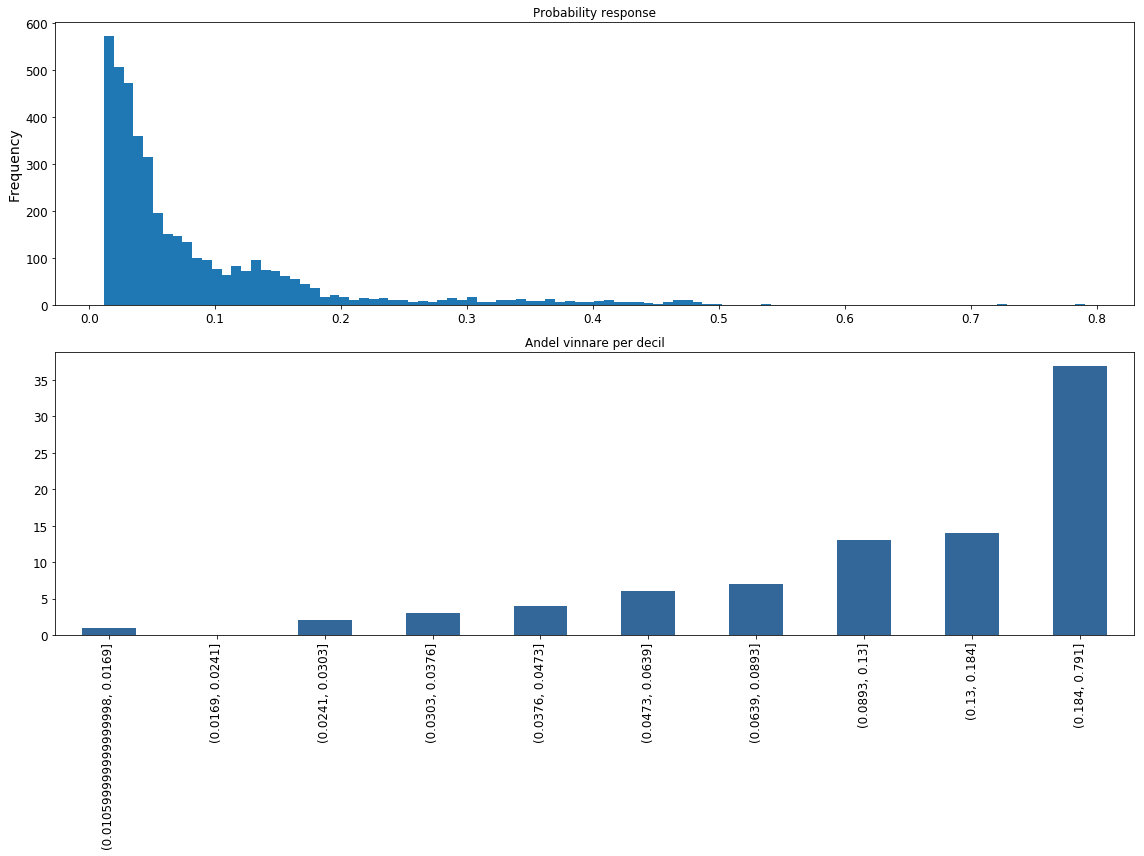

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

#df2[['VLP']].hist(bins=50, ax = ax1, label = 'Variansen på V75PROC - VLP')

df_valid.Prob.plot(kind = 'hist', bins = 100, title = 'Probability response', ax = ax1)


resp.plot(kind = 'bar', color=(0.2, 0.4, 0.6, 1),title = 'Andel vinnare per decil', ax = ax2)

save_fig('Probdist')

In [73]:
y_pred = np.where(prob >=0.174,1,0)
 
confusion_matrix(label_validate, y_pred)

array([[3548,  307],
       [ 205,  161]])

In [74]:
 
precision_score(label_validate, y_pred)

0.344017094017094

In [75]:
# True positive rate = Den totala andelen av sanna postiva vid en given cut of
recall_score(label_validate, y_pred)
 

0.43989071038251365

In [76]:
y_pred = np.where(prob >=0.131,1,0)
 
confusion_matrix(label_validate, y_pred)

array([[3234,  621],
       [ 152,  214]])

In [77]:
precision_score(label_validate, y_pred)

0.2562874251497006

In [78]:
# True positive rate = Den totala andelen av sanna postiva vid en given cut of
recall_score(label_validate, y_pred)

0.5846994535519126

In [79]:
# I df ligger roc statistiken. Plockar ut raden där 0.75 < tpr < 0.8. Vad är threshols
df.head()

,fpr,tpr,threshold
0,0.000000,0.002732,0.790726
1,0.000000,0.005464,0.783427
2,0.000259,0.005464,0.762450
3,0.000259,0.030055,0.500457
4,0.000519,0.030055,0.496532


In [80]:
f1 = df.tpr > 0.60
f2 = df.tpr < 0.62

In [81]:
df[f1 & f2]

,fpr,tpr,threshold
261,0.169390,0.601093,0.127866
262,0.170428,0.601093,0.127518
263,0.170428,0.603825,0.127518
264,0.170947,0.603825,0.127338
265,0.170947,0.606557,0.126987
266,0.173281,0.606557,0.126187
267,0.173281,0.609290,0.126185
268,0.173541,0.609290,0.125947
269,0.173541,0.612022,0.125849
270,0.178729,0.612022,0.124206


__Nu har vi modellen. Nu vill vi testa på våra undanlagda 9 omgångar för att se hur det lirar. Skapar testdatasetet och kör sedan igenom varje omgång. Flaggar upp alla över score 0.135 som vinnar och räknar sedan ut hur det fallit ut__

In [82]:
test_df.Datum.drop_duplicates()

Key
2016-07-09 00:00:001   2016-07-09
2016-10-01 00:00:001   2016-10-01
2016-12-10 00:00:001   2016-12-10
2017-02-11 00:00:001   2017-02-11
2017-04-29 00:00:001   2017-04-29
2017-08-16 00:00:001   2017-08-16
2017-08-23 00:00:001   2017-08-23
2017-12-25 00:00:001   2017-12-25
2018-03-03 00:00:001   2018-03-03
2018-06-16 00:00:001   2018-06-16
2018-07-05 00:00:001   2018-07-05
2018-11-11 00:00:001   2018-11-11
2018-11-25 00:00:001   2018-11-25
Name: Datum, dtype: datetime64[ns]

In [83]:
test_df[test_df.Datum == '2018-11-25']

,Datum,V75PROC,GRUPP,VLP,SVLP,VSVLP,VPN_SUM,VPN_SUM_ORD,VPK_SUM,VPK_SUM_ORD,...,A_R,T_R,SP_R,ToR,P_R,TK_R,Ex_R,R_R,Ts_R,Y
Key,,,,,,,,,,,,,,,,,,,,,
2018-11-25 00:00:001,2018-11-25,0.01,4,69.67,0.48,0.06,0.41,8,0.01,23,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,0
2018-11-25 00:00:001,2018-11-25,0.01,4,69.67,0.48,0.06,0.61,4,0.38,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-11-25 00:00:001,2018-11-25,0.02,3,69.67,0.48,0.06,0.49,6,0.60,3,...,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0,0
2018-11-25 00:00:001,2018-11-25,0.04,2,69.67,0.48,0.06,0.43,7,0.11,16,...,3.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,2,0
2018-11-25 00:00:001,2018-11-25,0.07,2,69.67,0.48,0.06,0.69,3,0.93,2,...,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,3,0
2018-11-25 00:00:001,2018-11-25,0.02,3,69.67,0.48,0.06,0.52,5,0.40,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-11-25 00:00:001,2018-11-25,0.82,1,69.67,0.48,0.06,1.43,1,1.86,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1
2018-11-25 00:00:001,2018-11-25,0.00,4,69.67,0.48,0.06,0.38,9,0.01,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-11-25 00:00:002,2018-11-25,0.04,4,4.98,2.74,0.74,0.04,14,0.25,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [84]:
# Plockar ut en omgång och scorar denna 

df_test1 = test_df[test_df.Datum == '2018-11-25'].drop('Datum', axis = 1)


In [85]:
len(df_test1.columns)

29

In [86]:
df_test1['GRUPP'] = df_test1.GRUPP.astype('object')

In [87]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 2018-11-25 00:00:001 to 2018-11-25 00:00:007
Data columns (total 29 columns):
V75PROC        75 non-null float64
GRUPP          75 non-null object
VLP            75 non-null float64
SVLP           75 non-null float64
VSVLP          75 non-null float64
VPN_SUM        75 non-null float64
VPN_SUM_ORD    75 non-null int64
VPK_SUM        75 non-null float64
VPK_SUM_ORD    75 non-null int64
VLPB           75 non-null float64
SVLPB          75 non-null float64
VSVLPB         75 non-null float64
E_P            75 non-null float64
E_P_Num        75 non-null int64
E_N            75 non-null float64
E_R            75 non-null float64
E_U            75 non-null float64
G_R            75 non-null float64
S_R            75 non-null float64
A_R            75 non-null float64
T_R            75 non-null float64
SP_R           75 non-null float64
ToR            75 non-null float64
P_R            75 non-null float64
TK_R           75 non-null float

In [88]:
df_test1.Y.sum()

7

In [89]:
# Testdata som modllen ska scoras på
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_test = full_pipeline.fit_transform(df_test1)
## En array som håller det vi vill predikter
label_test = df_test1["Y"].copy()

In [90]:
predict_test = rf.predict_proba(features_test)

In [91]:
y_pred_test = np.where( predict_test[:,1] > 0.135,1,0)
 
confusion_matrix(label_test, y_pred_test)

array([[58, 10],
       [ 0,  7]])

In [92]:
y_pred_test = np.where( predict_test[:,1] > 0.184,1,0)
 
confusion_matrix(label_test, y_pred_test)

array([[64,  4],
       [ 0,  7]])

__Nu itererar vi över alla testloppen__

In [93]:
def validering(Date):
    df_test1 = test_df[test_df.Datum == Date].drop('Datum', axis = 1)
    df_test1['GRUPP'] = df_test1.GRUPP.astype('object')
    features_test = full_pipeline.fit_transform(df_test1)
    label_test = df_test1["Y"].copy()
    predict_test = rf.predict_proba(features_test)
    y_pred_test = np.where( predict_test[:,1] > 0.135,1,0)
    confusion_matrix(label_test, y_pred_test)

In [94]:
df_tmp = test_df.Datum.drop_duplicates().to_frame().reset_index()
df_tmp

,Key,Datum
0,2016-07-09 00:00:001,2016-07-09
1,2016-10-01 00:00:001,2016-10-01
2,2016-12-10 00:00:001,2016-12-10
3,2017-02-11 00:00:001,2017-02-11
4,2017-04-29 00:00:001,2017-04-29
5,2017-08-16 00:00:001,2017-08-16
6,2017-08-23 00:00:001,2017-08-23
7,2017-12-25 00:00:001,2017-12-25
8,2018-03-03 00:00:001,2018-03-03
9,2018-06-16 00:00:001,2018-06-16


In [95]:
d_list = ['2017-08-16','2017-08-23','2018-11-11','2018-11-25']
for date in d_list:
    df_test1 = test_df[test_df.Datum == date].drop('Datum', axis = 1)
    df_test1['GRUPP'] = df_test1.GRUPP.astype('object')
    features_test = full_pipeline.fit_transform(df_test1)
    label_test = df_test1["Y"].copy()
    predict_test = rf.predict_proba(features_test)
    y_pred_test = np.where( predict_test[:,1] > 0.135,1,0)
    print(confusion_matrix(label_test, y_pred_test),date)

[[57 12]
 [ 2  5]] 2017-08-16
[[64  9]
 [ 1  6]] 2017-08-23
[[62 15]
 [ 3  4]] 2018-11-11
[[58 10]
 [ 0  7]] 2018-11-25


In [96]:
d_list = ['2017-08-16','2017-08-23','2018-11-11','2018-11-25']
for date in d_list:
    df_test1 = test_df[test_df.Datum == date].drop('Datum', axis = 1)
    df_test1['GRUPP'] = df_test1.GRUPP.astype('object')
    features_test = full_pipeline.fit_transform(df_test1)
    label_test = df_test1["Y"].copy()
    predict_test = rf.predict_proba(features_test)
    y_pred_test = np.where( predict_test[:,1] > 0.184,1,0)
    print(confusion_matrix(label_test, y_pred_test),date)
    

[[65  4]
 [ 2  5]] 2017-08-16
[[68  5]
 [ 3  4]] 2017-08-23
[[70  7]
 [ 3  4]] 2018-11-11
[[64  4]
 [ 0  7]] 2018-11-25


__Testar Åby 20190202__

In [97]:
df_aby = pd.read_excel('Åby2019-02-02.xlsx')

In [98]:
df_aby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 37 columns):
Datum          82 non-null datetime64[ns]
Arstid         82 non-null int64
Distans        82 non-null int64
Startsatt      82 non-null int64
Lopp           82 non-null int64
Plac           82 non-null int64
Hast           82 non-null int64
V75PROC        82 non-null float64
V_ODDS         82 non-null float64
GRUPP          82 non-null int64
VLP            82 non-null float64
VNUM           82 non-null int64
SVLP           82 non-null float64
VSVLP          82 non-null float64
VPN_SUM        82 non-null float64
VPN_SUM_ORD    82 non-null int64
VPK_SUM        82 non-null float64
VPK_SUM_ORD    82 non-null int64
VLPB           82 non-null float64
SVLPB          82 non-null float64
VSVLPB         82 non-null float64
E_P            82 non-null float64
E_P_Num        82 non-null int64
E_N            82 non-null float64
E_R            82 non-null float64
E_U            82 non-null float64
G_

In [99]:
df_aby['Y'] = np.where(df_aby['Plac'].isin([1]), 1,0)

In [100]:
df_aby.Y.sum()

7

In [101]:
date = '2019-02-02'
df_aby['GRUPP'] = df_aby.GRUPP.astype('object')
features_test = full_pipeline.fit_transform(df_aby)
label_test = df_aby["Y"].copy()
predict_test = rf.predict_proba(features_test)
y_pred_test = np.where( predict_test[:,1] > 0.131,1,0)
print(confusion_matrix(label_test, y_pred_test),date)

[[49 26]
 [ 0  7]] 2019-02-02


In [102]:
date = '2019-02-02'
y_pred_test = np.where( predict_test[:,1] > 0.184,1,0)
print(confusion_matrix(label_test, y_pred_test),date)

[[69  6]
 [ 0  7]] 2019-02-02


In [103]:
type(rf)

sklearn.ensemble.forest.RandomForestClassifier

__Sparar undan pipelineobjekt och modellobjekt för att kunna återanvänd senare__

In [104]:
from sklearn.externals import joblib

In [105]:
# Pipelineobjekt
joblib.dump(full_pipeline, 'Pipeline_v1.pkl')


['Pipeline_v1.pkl']

In [106]:
# Modellobjekt
joblib.dump(rf, 'Travmodel_v1.pkl')

['Travmodel_v1.pkl']

__Nu testar vi att läsa in modell- och pipelinebjekten__

In [107]:
my_model_loaded = joblib.load('Travmodel_v1.pkl')

In [109]:
my_pipeline_loaded = joblib.load('Pipeline_v1.pkl')

In [110]:
date = '2019-02-02'
df_aby['GRUPP'] = df_aby.GRUPP.astype('object')
features_test = my_pipeline_loaded.fit_transform(df_aby)
label_test = df_aby["Y"].copy()
predict_test = my_model_loaded.predict_proba(features_test)
y_pred_test = np.where( predict_test[:,1] > 0.131,1,0)
print(confusion_matrix(label_test, y_pred_test),date)

[[49 26]
 [ 0  7]] 2019-02-02
